In [290]:
%load_ext autoreload
%autoreload 2

from ff_energy.structure import Structure
from ff_energy.job import Job
from ff_energy.plot import plot_energy_MSE

# s = Structure("/home/boittier/charmm/mix3/jobs/pdbs/mix0.pdb")

kwargs = {"m_nproc": 4, "m_memory": 480, "m_queue": "short", 
          "m_basis": "avdz", "m_method": "hf",
          "chmpath": "/home/boittier/dev-release-dcm/build/cmake/charmm",
          "modules": "module load cmake/cmake-3.23.0-gcc-11.2.0-openmpi-4.1.3",
          "c_files": ["poly_hf.dcm"],
          "c_dcm_command": "open unit 11 card read name poly_hf.dcm \nDCM FLUX 11 IUDCM 11 TSHIFT XYZ 15",
          }

JOBDIR = "dimer3dtest"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
from pathlib import Path
import os
PDBPATH = Path("/home/boittier/charmm/test/dimer3d/")
pdbs = [_ for _ in os.listdir(PDBPATH) if _.endswith("pdb")]

In [248]:
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    j.generate_molpro()
    j.generate_charmm()

In [ ]:
# for x in *; do cd $x; cd charmm; sbatch *.slurm; cd ../..; done
# for x in *; do cd $x/monomers; for y in *.sh; do sbatch $y; done ; cd ../..; done

In [249]:
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    j.generate_coloumb_interactions()
    j.generate_polarization()

In [ ]:
# for x in *; do cd $x/coloumb; for y in *.sh; do sbatch $y; done ; cd ../..; done
# for x in *; do cd $x/polarization; for y in *.slurm; do sbatch $y; done ; cd ../..; done

In [250]:
# p_data = j.gather_data()

In [251]:
output = []
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    o = j.gather_data()
    output.append(o)

In [252]:
o = j.gather_data()

In [253]:
o["polarization"].sum()

QMMM        -152.077184
KEY        17-1_217-1_1
NOFIELD      -152.07717
pol           -0.008708
dtype: object

In [254]:
#  generate molpro jobs and wait
#  generate charmm jobs and wait
#  generate orbkit jobs

In [255]:
chm_df = pd.concat([_["charmm"] for _ in output])

In [256]:
ctot = pd.concat([_["coloumb_total"] for _ in output])

In [257]:
_ = pd.concat([_["polarization"].sum() for _ in output])

In [258]:
pol_df = pd.concat([_["pol_total"] for _ in output])

In [259]:
pol_df

,POL,KEY
7-3,-0.422327,7-3
3-1,-4.685572,3-1
8-2,-0.254271,8-2
3-3,-4.944746,3-3
9-3,-0.152607,9-3
...,...,...
6-2,-0.753791,6-2
20-1,-0.003873,20-1
7-2,-0.429040,7-2
19-1,-0.005012,19-1


In [260]:
#  convert molpro csv
converters = {i: lambda x: float(x.strip().replace("D","E")) * 627.503 * 10**(-3) for i in range(3,10)}
converters[0] = lambda x: x
converters[1] = lambda x: float(x.strip().replace("D","E"))
converters[2] = lambda x: float(x.strip().replace("D","E"))

#  read molpro csv
df = pd.read_csv("/home/boittier/pcbach/dimer3d/sapt.csv", converters=converters)
#  strip whitespace in column names
df = df.rename(columns=lambda x: x.strip())

In [261]:
df["KEY"] = df["KEYS"].apply(lambda x: x.strip())
df

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1
...,...,...,...,...,...,...,...,...,...,...,...
107,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5
108,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5
109,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5
110,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5


In [262]:
pol_3d = pd.merge(df, pol_df, on="KEY")
pol_3d = pd.merge(pol_3d, ctot)
pol_3d = pd.merge(pol_3d, chm_df)
pol_3d

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY,POL,ECOL,TOTAL,ELEC,VDW
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1,-17.551890,-61.301508,55966.19531,-63.31429,11137.70216
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1,-8.617284,-60.013564,1459.81164,-28.09761,477.46500
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1,-4.685572,-36.182925,102.77170,-16.94156,55.36028
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1,-2.561838,-20.520058,15.55905,-11.13109,10.23080
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1,-1.387239,-11.966885,14.77608,-7.69261,2.08525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5,-0.040499,-0.916508,15.70353,-0.86105,-0.08670
76,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5,-0.013901,-0.474694,15.56477,-0.45225,-0.03643
77,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5,-0.005636,-0.270469,15.51919,-0.25896,-0.01640
78,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5,-0.000855,-0.081184,15.57066,-0.07809,-0.00283


(1.0, 8.0)

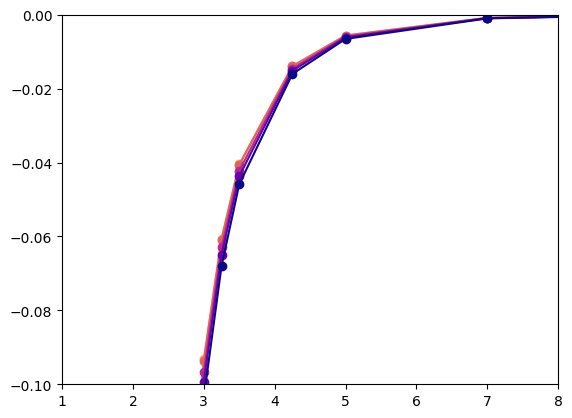

In [263]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.plasma_r(np.linspace(0, 1, len(TS)))
TS = list(set(df["TS"]))
TS.sort()

ax = plt.figure().add_subplot()

for i, ts in enumerate(TS):
    tmp = pol_3d[pol_3d["TS"] == ts]
    tmp = tmp[tmp["RS"] > 0]
    # ax.plot(tmp["RS"], tmp["ETOT"] - tmp["ELST"], "-o",  c=colors[i])
    ax.plot(tmp["RS"], tmp["POL"], "-o",  c=colors[i])
    
plt.ylim(-.1,0)
# plt.yscale("log")
plt.axhline(0, c="k", linewidth=0.1)
plt.xlim(1,8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1.5, 3.0)

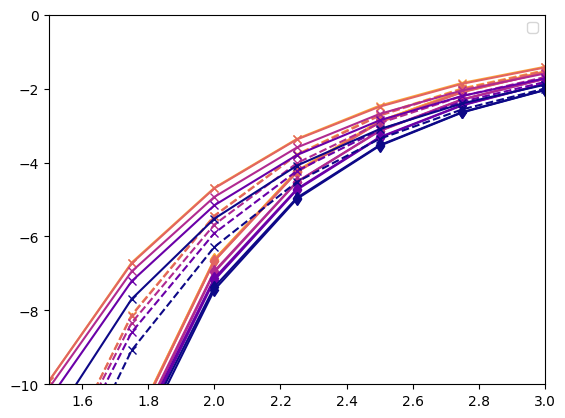

In [269]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.plasma_r(np.linspace(0, 1, len(TS)))
TS = list(set(df["TS"]))
TS.sort()

ax = plt.figure().add_subplot()

for i, ts in enumerate(TS):
    tmp = pol_3d[pol_3d["TS"] == ts]
    tmp = tmp[tmp["RS"] > 0]
    # ax.plot(tmp["RS"], tmp["ETOT"] - tmp["ELST"], "-o",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ECOL"], "-d",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELST"], "-d",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELEC"], "-x",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELEC"] + tmp["POL"], "--x",  c=colors[i])
    
plt.legend()
plt.ylim(-10,0)
plt.axhline(0, c="k", linewidth=0.1)
plt.xlim(1.5,3)

In [268]:
j.kwargs

{'m_nproc': 4,
 'm_memory': 480,
 'm_queue': 'short',
 'm_basis': 'avdz',
 'm_method': 'hf',
 'chmpath': '/home/boittier/dev-release-dcm/build/cmake/charmm',
 'modules': 'module load cmake/cmake-3.23.0-gcc-11.2.0-openmpi-4.1.3',
 'c_files': ['poly_hf.dcm'],
 'c_dcm_command': 'open unit 11 card read name poly_hf.dcm \nDCM FLUX 11 IUDCM 11 TSHIFT XYZ 15'}

In [273]:
pol_3d["ELECpol"] = pol_3d["ELEC"] + pol_3d["POL"]

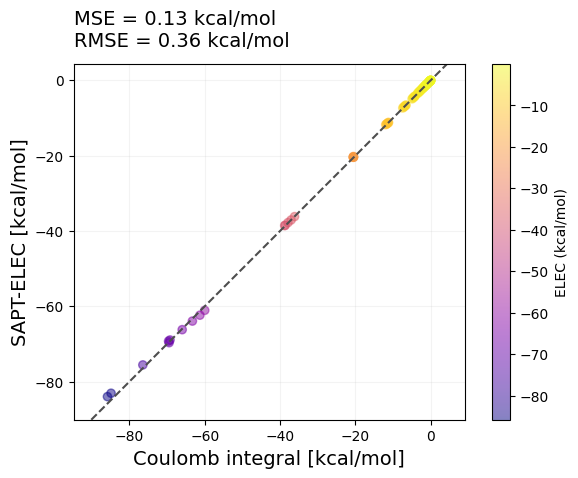

In [291]:
plot_energy_MSE(pol_3d, "ECOL", "ELST", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="SAPT-ELEC [kcal/mol]")

plt.savefig("sapt_vs_ci.pdf", bbox_inches="tight")

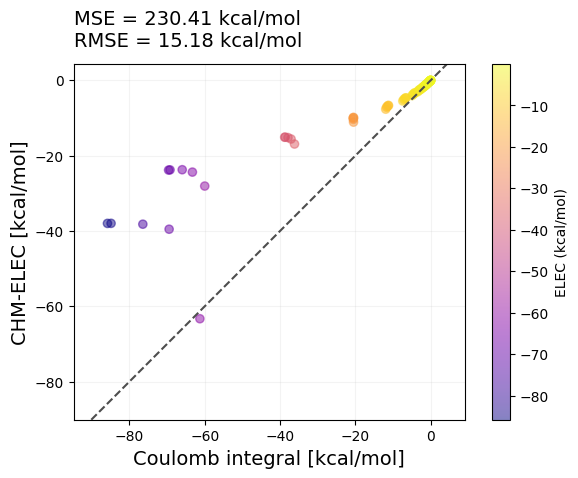

In [292]:
plot_energy_MSE(pol_3d, "ECOL", "ELEC", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="CHM-ELEC [kcal/mol]")
plt.savefig("chm_vs_ci.pdf", bbox_inches="tight")

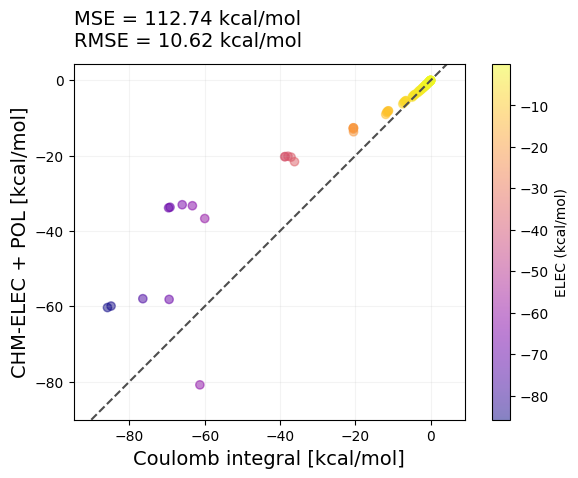

In [293]:
plot_energy_MSE(pol_3d, "ECOL", "ELECpol", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="CHM-ELEC + POL [kcal/mol]")
plt.savefig("chm_pol_vs_ci.pdf", bbox_inches="tight")

In [280]:
pol_3d

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY,POL,ECOL,TOTAL,ELEC,VDW,MSE,ELECpol
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1,-17.551890,-61.301508,55966.19531,-63.31429,11137.70216,3.827764e+02,-80.866180
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1,-8.617284,-60.013564,1459.81164,-28.09761,477.46500,5.428280e+02,-36.714894
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1,-4.685572,-36.182925,102.77170,-16.94156,55.36028,2.118711e+02,-21.627132
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1,-2.561838,-20.520058,15.55905,-11.13109,10.23080,4.660970e+01,-13.692928
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1,-1.387239,-11.966885,14.77608,-7.69261,2.08525,8.334978e+00,-9.079849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5,-0.040499,-0.916508,15.70353,-0.86105,-0.08670,2.237818e-04,-0.901549
76,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5,-0.013901,-0.474694,15.56477,-0.45225,-0.03643,7.298781e-05,-0.466151
77,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5,-0.005636,-0.270469,15.51919,-0.25896,-0.01640,3.448870e-05,-0.264596
78,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5,-0.000855,-0.081184,15.57066,-0.07809,-0.00283,5.012296e-06,-0.078945
